In [1]:
import tensorflow as tf

from texture.layers import DARTSEdge
from texture.ops import bilinear_pooling
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Conv2D, BatchNormalization, Concatenate, MaxPool2D, Input, Lambda, Dense, GlobalAveragePooling2D

Using TensorFlow backend.


In [2]:
def dilation_branch(x, f_in, f_out, r, name='unnammed_conv'):
    '''
    Combination of 1x1 conv compression and 3x3 dilated conv expansion.
    '''
    x = Conv2D(f_in, (1,1), activation='relu', name=name+'_1x1_'+str(r))(x)

    #conv_init = ConvolutionAware()
    x = Conv2D(f_out, (3,3), padding='same', dilation_rate=(r,r), activation='relu', #kernel_initializer=conv_init,
               name=name+'_dilate_'+str(r))(x)

    return x

def dilation_block(x,
                   branches,
                   in_filters,
                   out_filters,
                   pool_size=None,
                   name='block'):
    '''Block with branches defined by dilation rates of `branches`.

    Parameters
    ----------
    x : Tensor, BxHxWxC
        Input Tensor
    branches : iterable(int)
        Each item defines a branch with dilation_rate=item
    in_filters : iterable or int
        Output filters for 1x1 reduction, per branch.
        If iterable, must have len == len(branches). If int, assumed all branches the same.
    out_filters : iter
        Output filters for 3x3 dilated conv, per branch.
        If iterable, must have len == len(branches). If int, assumed all branches the same.
    pool_size : tuple(int), or `None`
        If not `None`, passed to MaxPool2D on block output.
    name : str, optional
        Base name for block/branch layer names

    Returns
    -------
    Output of passing `x` through the constructed block.
    '''

    args = [branches, in_filters, out_filters]
    if all([hasattr(f, '__iter__') for f in args]):
        print([lambda f: hasattr(f, '__iter__') for f in args])
        assert len(set([len(x) for x in args])) == 1, \
            'if iterables, in_filters & out_filters must have same len as branches'
    elif isinstance(in_filters, int) and isinstance(out_filters, int):
        # if both ints
        in_filters = [in_filters] * len(branches)
        out_filters = [out_filters] * len(branches)
    else:
        raise ValueError('in_filters & out_filters must be both `iterable`, or both `int`')

    branch_outputs = []
    for rate, f_in, f_out in zip(branches, in_filters, out_filters):
        branch = dilation_branch(x, f_in, f_out, rate, name=name)
        branch_outputs.append(branch)
    #block_output = Concatenate()(branch_outputs)

    if pool_size is not None:
        branch_outputs = [MaxPool2D(pool_size=pool_size)(branch) for branch in branch_outputs]
    
    block_output = Lambda(lambda x: tf.stack(x, axis=1))(branch_outputs)

    return block_output

In [43]:
from texture.ops import bilinear_pooling

input_image = Input(shape=(224, 224, 3))

x = Conv2D(64, (7,7), padding='same', activation='relu', name='entry_conv')(input_image)

x = dilation_block(x, [1,2,3], 32, 64, pool_size=2)

x = DARTSEdge()(x)

x = dilation_block(x, [1,2,3], 48, 96, pool_size=2, name='block2')

x = DARTSEdge()(x)

x = dilation_block(x, [1,2,3], 64, 128, pool_size=2, name='block3')

x = DARTSEdge()(x)

x = Conv2D(64, (1,1), activation='relu', name='reduce_conv')(x)

x = Lambda(bilinear_pooling, name='bilinear_pooling')([x, x])

preds = Dense(47, activation='softmax')(x)

model = KerasModel(inputs=input_image, outputs=preds)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
entry_conv (Conv2D)             (None, 224, 224, 64) 9472        input_7[0][0]                    
__________________________________________________________________________________________________
block_1x1_1 (Conv2D)            (None, 224, 224, 32) 2080        entry_conv[0][0]                 
__________________________________________________________________________________________________
block_1x1_2 (Conv2D)            (None, 224, 224, 32) 2080        entry_conv[0][0]                 
__________________________________________________________________________________________________
block_1x1_

In [12]:
class DARTSrecompiler(tf.keras.callbacks.Callback):
    def __init__(self, loss='categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(), 
                       metrics=['accuracy']):
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
    
    def on_train_begin(self, batch, logs={}):
        for layer in self.model.layers:
            layer.trainable = False if type(layer) is DARTSEdge else True 
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)
    
    def on_batch_end(self, batch, logs=[]):
        for layer in self.model.layers:
            layer.trainable = not layer.trainable
        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=self.metrics)

In [28]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[1. 1. 1.]
darts_edge_14
[1. 1. 1.]
darts_edge_15
[1. 1. 1.]


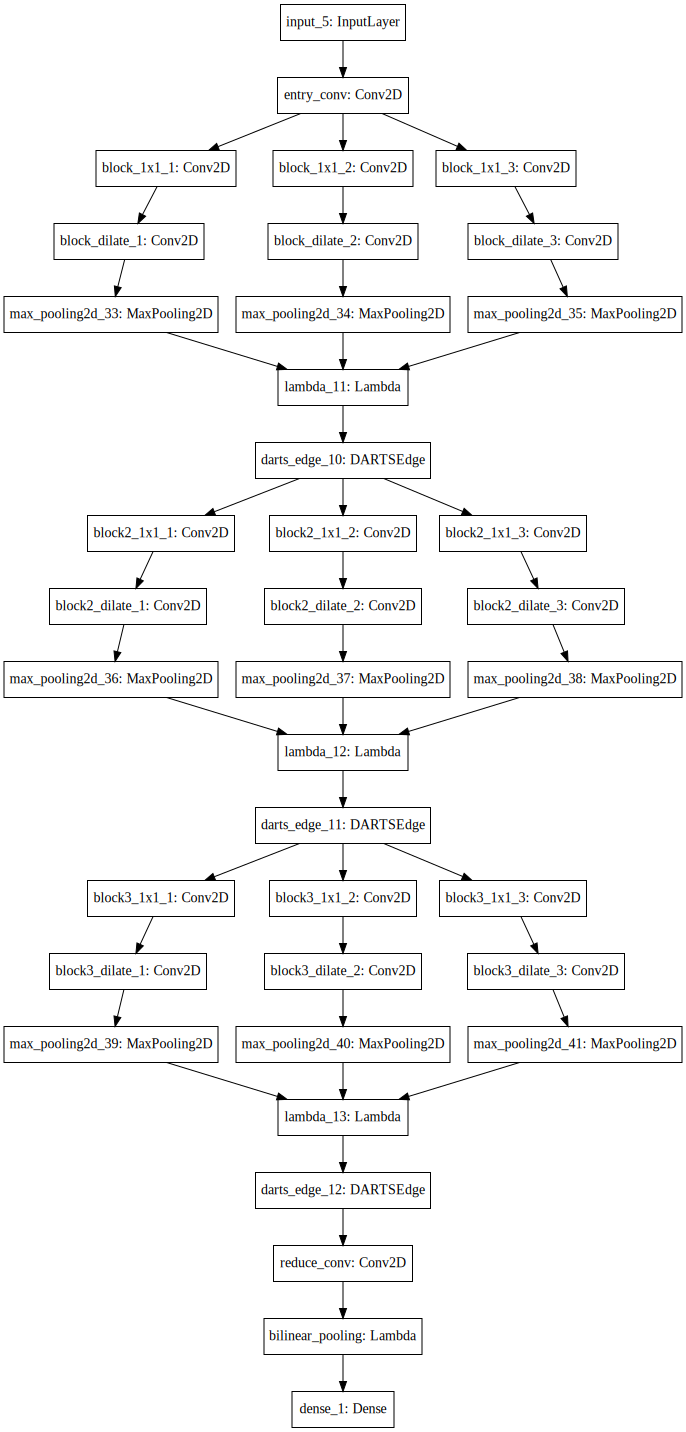

In [17]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [5]:
from texture.datasets import FMDDataset

In [6]:
dtd = DTDDataset('/home/administrator/Dropbox/benchmark/dtd')
dtd.load_or_generate_data()

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [44]:
from texture.datasets import DatasetSequence

trainseq = DatasetSequence(dtd.X_train, dtd.y_train, 8)
testseq = DatasetSequence(dtd.X_test, dtd.y_test, 8)

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])

In [45]:
hist = model.fit_generator(
    trainseq,
    epochs=50,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/50
470/470 [==============================] - 118s 251ms/step - loss: 4.2894 - acc: 0.0085 - val_loss: 4.3906 - val_acc: 0.0213
Epoch 2/50
470/470 [==============================] - 103s 220ms/step - loss: 3.9061 - acc: 0.0194 - val_loss: 3.8664 - val_acc: 0.0213
Epoch 3/50
470/470 [==============================] - 102s 217ms/step - loss: 3.8712 - acc: 0.0189 - val_loss: 3.8641 - val_acc: 0.0213
Epoch 4/50
470/470 [==============================] - 102s 217ms/step - loss: 3.8711 - acc: 0.0210 - val_loss: 3.8615 - val_acc: 0.0213
Epoch 5/50
470/470 [==============================] - 101s 216ms/step - loss: 3.8725 - acc: 0.0191 - val_loss: 3.8628 - val_acc: 0.0213
Epoch 6/50
470/470 [==============================] - 105s 222ms/step - loss: 3.8729 - acc: 0.0160 - val_loss: 3.8604 - val_acc: 0.0213
Epoch 7/50
470/470 [==============================] - 105s 223ms/step - loss: 3.8713 - acc: 0.0176 - val_loss: 3.8639 - val_acc: 0.0287
Epoch 8/50
470/470 [============================

In [46]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_16
[1.171234  1.6283685 1.4291697]
darts_edge_17
[0.4780452  0.80093074 1.2915331 ]
darts_edge_18
[1.2876794 1.6365566 1.9612592]


In [32]:
hist2 = model.fit_generator(
    trainseq,
    epochs=10,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/10
470/470 [==============================] - 116s 248ms/step - loss: 3.6444 - acc: 0.0819 - val_loss: 3.5904 - val_acc: 0.1000
Epoch 2/10
470/470 [==============================] - 117s 248ms/step - loss: 3.6038 - acc: 0.0928 - val_loss: 3.5429 - val_acc: 0.1146
Epoch 3/10
470/470 [==============================] - 117s 249ms/step - loss: 3.5462 - acc: 0.1141 - val_loss: 3.4810 - val_acc: 0.1359
Epoch 4/10
470/470 [==============================] - 119s 252ms/step - loss: 3.4723 - acc: 0.1210 - val_loss: 3.3888 - val_acc: 0.1505
Epoch 5/10
470/470 [==============================] - 117s 250ms/step - loss: 3.3930 - acc: 0.1468 - val_loss: 3.3746 - val_acc: 0.1362
Epoch 6/10
470/470 [==============================] - 118s 250ms/step - loss: 3.3264 - acc: 0.1508 - val_loss: 3.2673 - val_acc: 0.1721
Epoch 7/10
470/470 [==============================] - 119s 253ms/step - loss: 3.2412 - acc: 0.1801 - val_loss: 3.1659 - val_acc: 0.1920
Epoch 8/10
470/470 [============================

In [33]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[1.0231745 1.0238837 0.9735908]
darts_edge_14
[0.9870972 1.0018187 1.0265061]
darts_edge_15
[0.85552585 0.91142464 1.1801836 ]


In [34]:
hist3 = model.fit_generator(
    trainseq,
    epochs=10,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/10
470/470 [==============================] - 121s 257ms/step - loss: 2.9490 - acc: 0.2348 - val_loss: 2.8598 - val_acc: 0.2574
Epoch 2/10
470/470 [==============================] - 123s 262ms/step - loss: 2.8737 - acc: 0.2569 - val_loss: 2.8024 - val_acc: 0.2604
Epoch 3/10
470/470 [==============================] - 119s 254ms/step - loss: 2.8108 - acc: 0.2625 - val_loss: 2.6952 - val_acc: 0.3016
Epoch 4/10
470/470 [==============================] - 120s 254ms/step - loss: 2.7323 - acc: 0.2811 - val_loss: 2.6493 - val_acc: 0.2981
Epoch 5/10
470/470 [==============================] - 120s 255ms/step - loss: 2.6682 - acc: 0.2960 - val_loss: 2.5756 - val_acc: 0.3112
Epoch 6/10
470/470 [==============================] - 118s 251ms/step - loss: 2.5959 - acc: 0.3104 - val_loss: 2.5318 - val_acc: 0.3324
Epoch 7/10
470/470 [==============================] - 118s 252ms/step - loss: 2.5441 - acc: 0.3245 - val_loss: 2.4387 - val_acc: 0.3460
Epoch 8/10
470/470 [============================

In [35]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[0.9879457  1.0587778  0.99098384]
darts_edge_14
[0.9599793 1.0667883 1.024362 ]
darts_edge_15
[0.84282124 1.0452721  1.109983  ]


In [36]:
hist4 = model.fit_generator(
    trainseq,
    epochs=10,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/10
470/470 [==============================] - 119s 253ms/step - loss: 2.2581 - acc: 0.3939 - val_loss: 2.1344 - val_acc: 0.4370
Epoch 2/10
470/470 [==============================] - 119s 253ms/step - loss: 2.1886 - acc: 0.4080 - val_loss: 2.1159 - val_acc: 0.4271
Epoch 3/10
470/470 [==============================] - 119s 252ms/step - loss: 2.1220 - acc: 0.4319 - val_loss: 1.9806 - val_acc: 0.4689
Epoch 4/10
470/470 [==============================] - 119s 252ms/step - loss: 2.0558 - acc: 0.4415 - val_loss: 1.9557 - val_acc: 0.4681
Epoch 5/10
470/470 [==============================] - 122s 260ms/step - loss: 1.9689 - acc: 0.4755 - val_loss: 1.8238 - val_acc: 0.5191
Epoch 6/10
470/470 [==============================] - 118s 250ms/step - loss: 1.9084 - acc: 0.4816 - val_loss: 1.8054 - val_acc: 0.5266
Epoch 7/10
470/470 [==============================] - 119s 253ms/step - loss: 1.8299 - acc: 0.5072 - val_loss: 1.7316 - val_acc: 0.5551
Epoch 8/10
470/470 [============================

In [37]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[0.93426156 1.0691946  1.0425295 ]
darts_edge_14
[0.9379819 1.1161715 1.0242034]
darts_edge_15
[0.88083726 1.1350859  1.029621  ]


In [38]:
hist5 = model.fit_generator(
    trainseq,
    epochs=10,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/10
470/470 [==============================] - 116s 248ms/step - loss: 1.5443 - acc: 0.5979 - val_loss: 1.3913 - val_acc: 0.6529
Epoch 2/10
470/470 [==============================] - 118s 251ms/step - loss: 1.4496 - acc: 0.6348 - val_loss: 1.3162 - val_acc: 0.6840
Epoch 3/10
470/470 [==============================] - 118s 251ms/step - loss: 1.3764 - acc: 0.6537 - val_loss: 1.2440 - val_acc: 0.6981
Epoch 4/10
470/470 [==============================] - 118s 251ms/step - loss: 1.2997 - acc: 0.6816 - val_loss: 1.1288 - val_acc: 0.7487
Epoch 5/10
470/470 [==============================] - 118s 252ms/step - loss: 1.2056 - acc: 0.7168 - val_loss: 1.1373 - val_acc: 0.7380
Epoch 6/10
470/470 [==============================] - 118s 251ms/step - loss: 1.1094 - acc: 0.7359 - val_loss: 0.9910 - val_acc: 0.7915
Epoch 7/10
470/470 [==============================] - 118s 252ms/step - loss: 1.0296 - acc: 0.7668 - val_loss: 0.9242 - val_acc: 0.8327
Epoch 8/10
470/470 [============================

In [39]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[0.90637493 1.0704253  1.0726364 ]
darts_edge_14
[0.91798943 1.1424773  1.0332731 ]
darts_edge_15
[0.93993866 1.1524559  0.9814369 ]


In [40]:
hist6 = model.fit_generator(
    trainseq,
    epochs=10,
    validation_data=testseq,
    shuffle=False,
    callbacks = [] #[DARTSrecompiler()]
)

Epoch 1/10
470/470 [==============================] - 116s 246ms/step - loss: 0.7456 - acc: 0.8612 - val_loss: 1.3175 - val_acc: 0.6266
Epoch 2/10
470/470 [==============================] - 119s 253ms/step - loss: 0.7429 - acc: 0.8612 - val_loss: 0.5342 - val_acc: 0.9383
Epoch 3/10
470/470 [==============================] - 119s 253ms/step - loss: 0.6356 - acc: 0.8891 - val_loss: 0.5743 - val_acc: 0.9109
Epoch 4/10
470/470 [==============================] - 118s 251ms/step - loss: 0.5337 - acc: 0.9277 - val_loss: 0.4527 - val_acc: 0.9500
Epoch 5/10
470/470 [==============================] - 121s 257ms/step - loss: 0.4783 - acc: 0.9356 - val_loss: 0.4292 - val_acc: 0.9508
Epoch 6/10
470/470 [==============================] - 118s 251ms/step - loss: 0.4480 - acc: 0.9380 - val_loss: 0.3992 - val_acc: 0.9561
Epoch 7/10
470/470 [==============================] - 118s 252ms/step - loss: 0.4197 - acc: 0.9481 - val_loss: 0.4006 - val_acc: 0.9423
Epoch 8/10
470/470 [============================

In [41]:
for layer in model.layers:
    if type(layer) is DARTSEdge:
        print(layer.name)
        print(layer.get_weights()[0].squeeze())

darts_edge_13
[0.879937  1.0721195 1.1026733]
darts_edge_14
[0.9017446 1.1581132 1.0434673]
darts_edge_15
[0.9762555  1.1712674  0.94419366]


In [42]:
testseq = DatasetSequence(dtd.X_test, dtd.y_test, 8)
model.evaluate_generator(testseq)

[3.4758484690747364, 0.2670212765957447]

In [21]:
model.output

<tf.Tensor 'dense_1/Softmax:0' shape=(?, 47) dtype=float32>

In [22]:
model.trainable_weights

[<tf.Variable 'darts_edge_10/op_weights:0' shape=(1, 3, 1, 1, 1) dtype=float32>,
 <tf.Variable 'darts_edge_11/op_weights:0' shape=(1, 3, 1, 1, 1) dtype=float32>,
 <tf.Variable 'darts_edge_12/op_weights:0' shape=(1, 3, 1, 1, 1) dtype=float32>]

In [23]:
model.non_trainable_weights

[<tf.Variable 'entry_conv_4/kernel:0' shape=(7, 7, 3, 64) dtype=float32>,
 <tf.Variable 'entry_conv_4/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'block_1x1_1_4/kernel:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Variable 'block_1x1_1_4/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'block_1x1_2_4/kernel:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Variable 'block_1x1_2_4/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'block_1x1_3_4/kernel:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Variable 'block_1x1_3_4/bias:0' shape=(32,) dtype=float32>,
 <tf.Variable 'block_dilate_1_4/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'block_dilate_1_4/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'block_dilate_2_4/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'block_dilate_2_4/bias:0' shape=(64,) dtype=float32>,
 <tf.Variable 'block_dilate_3_4/kernel:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Variable 'block_dilate_3_4/bias:0' shape=(64,) dtype=float32>

In [24]:
from tensorflow.keras import backend as K

In [25]:
K.gradients(model.output, model.trainable_weights)

[<tf.Tensor 'gradients/darts_edge_10/transpose_grad/transpose:0' shape=(1, 3, 1, 1, 1) dtype=float32>,
 <tf.Tensor 'gradients/darts_edge_11/transpose_grad/transpose:0' shape=(1, 3, 1, 1, 1) dtype=float32>,
 <tf.Tensor 'gradients/darts_edge_12/transpose_grad/transpose:0' shape=(1, 3, 1, 1, 1) dtype=float32>]

In [26]:
K.gradients(model.output, model.non_trainable_weights)

[<tf.Tensor 'gradients_1/entry_conv_4/Conv2D_grad/Conv2DBackpropFilter:0' shape=(7, 7, 3, 64) dtype=float32>,
 <tf.Tensor 'gradients_1/entry_conv_4/BiasAdd_grad/BiasAddGrad:0' shape=(64,) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_1_4/Conv2D_grad/Conv2DBackpropFilter:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_1_4/BiasAdd_grad/BiasAddGrad:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_2_4/Conv2D_grad/Conv2DBackpropFilter:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_2_4/BiasAdd_grad/BiasAddGrad:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_3_4/Conv2D_grad/Conv2DBackpropFilter:0' shape=(1, 1, 64, 32) dtype=float32>,
 <tf.Tensor 'gradients_1/block_1x1_3_4/BiasAdd_grad/BiasAddGrad:0' shape=(32,) dtype=float32>,
 <tf.Tensor 'gradients_1/block_dilate_1_4/Conv2D_grad/Conv2DBackpropFilter:0' shape=(3, 3, 32, 64) dtype=float32>,
 <tf.Tensor 'gradients_1/block_dilate_1_4/BiasAdd_grad/BiasA